<a href="https://colab.research.google.com/github/cjpdrury/evidence_networks/blob/fluxes/evidence_network_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evidence Network example

In [1]:
# install this version of tf to use decayed lr metric
!pip install tensorflow==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 53.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing insta

In [2]:
!pip install optuna
!pip install optuna.integration


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.7 MB/s eta 0:00:00


In [3]:

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug  1 09:40:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import numpy as np
from scipy.stats import norm, multivariate_normal
import sys, os, time, gc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Input,ReLU
from tensorflow.keras import optimizers, callbacks

from tensorflow.keras.layers import concatenate, BatchNormalization

import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import optuna
from optuna.integration import TFKerasPruningCallback

import requests
import time
import h5py


import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['image.cmap'] = 'coolwarm'
print(tf.config.list_physical_devices('GPU'))
tf.print(tf.constant([0.0]))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[0]
2.8.0


In [5]:
from google.colab import drive
drive.mount('/content/drive')
# !cd /content/drive/MyDrive/ML_Intern/

path = '/content/drive/MyDrive/ML_Intern'



Mounted at /content/drive


## Write flux data to numpy
The data is stored as two HDF5 files, containing SIMBA and TNG simulations. The following cell only needs to be ran once, to store the data as a numpy file.

In [ ]:
# for each file in TNG and SIMBA, extract chosen fluxes.
f_TNG = h5py.File(path+'/TNG_master.hdf5', 'r')
f_SIM = h5py.File(path+'/simba_master.hdf5', 'r')


sloan_TNG, sloan_SIM, galex_TNG,galex_SIM = [],[],[],[]

# loop through each folder. Extract all galaxies from chosen filter.
for i in range(len(f_TNG.keys())):
  data = np.array(f_TNG[str(i)]['intrinsic']['SLOAN']['SDSS.g'])
  sloan_TNG.append(data)
  data = np.array(f_TNG[str(i)]['intrinsic']['GALEX']['GALEX.FUV'])
  galex_TNG.append(data)


for i in range(len(f_SIM.keys())):
  data = np.array(f_SIM[str(i)]['intrinsic']['SLOAN']['SDSS.g'])
  sloan_SIM.append(data)
  data = np.array(f_SIM[str(i)]['intrinsic']['GALEX']['GALEX.FUV'])
  galex_SIM.append(data)


flux_TNG = np.stack((np.concatenate(sloan_TNG).ravel(), np.concatenate(galex_TNG).ravel()), axis=1)
flux_SIM = np.stack((np.concatenate(sloan_SIM).ravel(), np.concatenate(galex_SIM).ravel()), axis=1)

np.save(path+'/flux_TNG.npy',flux_TNG)
np.save(path+'/flux_SIMBA.npy',flux_SIM)

## Load flux data from numpy file

In [6]:
# unpack data
flux_TNG = np.load(path+'/flux_TNG.npy')
flux_SIM = np.load(path+'/flux_SIMBA.npy')
print(np.shape(flux_TNG))

# get headers and convert to pandas
header = 'sloan_g | galex_fuv'
header = header.split('|')

df_TNG = pd.DataFrame(flux_TNG, columns=header)
df_SIM = pd.DataFrame(flux_SIM, columns=header)

# add model labels 'm'
df_TNG['m'] = np.zeros(df_TNG.shape[0])
df_SIM['m'] = np.ones(df_SIM.shape[0])

df_TNG.head()

(2413891, 2)


,sloan_g,galex_fuv,m
0,1.008265e+30,3.683015e+29,0.0
1,2.232865e+29,1.797155e+29,0.0
2,4.372902e+28,1.415112e+27,0.0
3,8.979900e+27,4.046966e+27,0.0
4,4.124089e+28,3.872917e+27,0.0


In [7]:
# assign label of 0 for IllustrisTNG and 1 for SIMBA
flux_TNG = np.append(flux_TNG, np.zeros((len(flux_TNG[:,0]),1)) ,axis=1)
flux_SIM = np.append(flux_SIM, np.ones((len(flux_SIM[:,0]),1)) ,axis=1)

In [8]:
# combine into one dataset
train_flux = np.append(flux_TNG,flux_SIM, axis=0 )

## Produce training, validation and testing data
Note that some galaxies had zero-valued flux. These were removed. The fluxes are scaled to have a mean of zero and standard deviation of 1.

In [9]:
# randomly sample from training data

n_sample = 500000
# n_sample = train_data.shape[0]

choices = np.random.choice(train_flux.shape[0],
                                  size=n_sample,
                                  replace=False)
train_flux = train_flux[choices,:]
print(train_flux.shape)


# separate training, validation and test data
x_train, x_test, y_train, y_test = train_test_split(train_flux[:,:-1], train_flux[:,-1], test_size=0.20, shuffle=True, random_state=45)
x_train, x_val, y_train, y_val = train_test_split(x_train[:,:], y_train[:], test_size=0.20, shuffle=True, random_state=46)

(500000, 3)


In [10]:
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape,y_test.shape )

(320000, 2) (80000, 2) (100000, 2) (320000,) (80000,) (100000,)


In [11]:
# remove zero valued fluxes.
y_train = y_train[~np.all(x_train == 0, axis=1)]
x_train = x_train[~np.all(x_train == 0, axis=1)]



In [12]:
print(np.mean(x_train[:,0]), np.std(x_train[:,0]), np.max(x_train[:,0]), np.min(x_train[:,0]))

9.940299648978128e+27 8.502284305429028e+28 1.245713535904313e+31 1.535242993355888e+24


(array([3.44612054e-04, 1.29229520e-03, 3.44612054e-03, 7.46659451e-03,
        1.50193420e-02, 1.62254842e-02, 2.07915939e-02, 2.74253760e-02,
        2.73966583e-02, 2.01885228e-02, 2.28592663e-02, 3.11873909e-02,
        5.17492435e-02, 4.11237051e-02, 3.26232745e-02, 3.41740287e-02,
        4.12098581e-02, 4.19565176e-02, 4.67810864e-02, 5.08589957e-02,
        4.72692868e-02, 4.79010755e-02, 4.96528535e-02, 5.13759137e-02,
        5.07441250e-02, 5.18066788e-02, 5.06579720e-02, 4.79297932e-02,
        4.87338880e-02, 4.80446639e-02, 4.69246747e-02, 4.86764526e-02,
        4.70969807e-02, 4.75277458e-02, 4.49718731e-02, 4.65800627e-02,
        4.49718731e-02, 4.92795237e-02, 5.12610431e-02, 5.64015062e-02,
        5.53963877e-02, 5.76938014e-02, 6.21737581e-02, 6.83480574e-02,
        7.02147060e-02, 7.90023134e-02, 8.79909445e-02, 1.01114920e-01,
        1.20011148e-01, 1.41003765e-01, 1.64896868e-01, 1.93700692e-01,
        2.51193470e-01, 2.37638729e-01, 2.13803062e-01, 1.969457

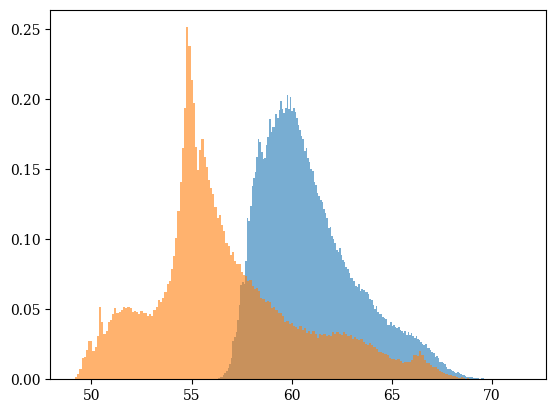

In [13]:
# check distributions
plt.hist(np.log(x_train[:,0]),bins=200, density=True, alpha=0.6)
plt.hist(np.log(x_train[:,1]),bins=200, density=True, alpha=0.6)

In [14]:
np.max(x_test)

1.2120585222004885e+31

In [15]:
# normalise each set of data.

x_train_scaled = np.copy(x_train)
x_train_scaled[:,:2] = np.log(x_train_scaled[:,:2])
scaler = StandardScaler()
scaler.fit(x_train_scaled)
x_train_scaled = scaler.transform(x_train_scaled)/20.+0.5

def data_scaler(data):
    """
    Scales input testing and validation data
    """

    data_scaled = np.copy(data)
    data_scaled[:,:2] = np.log(data[:,:2])
    data_scaled = scaler.transform(data_scaled)/20.+0.5

    return data_scaled

x_test_scaled = data_scaler(x_test)
x_val_scaled = data_scaler(x_val)

In [16]:
print(np.mean(x_test_scaled[:,1]), np.std(x_test_scaled[:,1]), np.max(x_test_scaled[:,1]), np.min(x_test_scaled[:,1]))

0.5001377657313346 0.04985508001214593 0.6857648975899675 0.4005187568981385


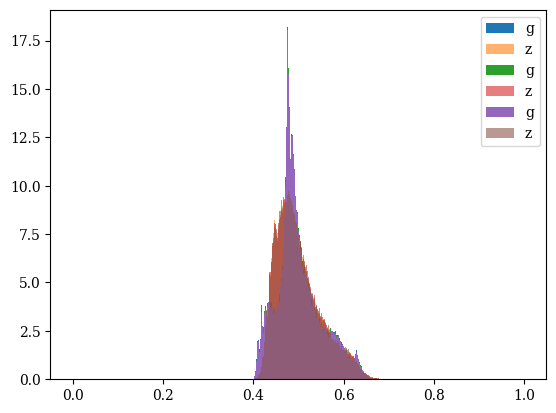

In [17]:
# check distributions match
_ = plt.hist(x_train_scaled[:,1],bins=np.linspace(-0,1,512),density=True, label='g')
_ = plt.hist(x_train_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True, label='z')

_ = plt.hist(x_val_scaled[:,1],bins=np.linspace(-0,1,512),density=True, label='g')
_ = plt.hist(x_val_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True, label='z')

_ = plt.hist(x_test_scaled[:,1],bins=np.linspace(-0,1,512),density=True, label='g')
_ = plt.hist(x_test_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True, label='z')

plt.legend()

In [18]:
# check the fraction of each model is the same in each set
print(np.mean(y_train), np.mean(y_val),np.mean(y_test) )




0.5639875 0.563525 0.56416


## Define functions for network

In [19]:
def smooth_sign(x, k =100.):

    return 2.*tf.math.sigmoid(k*x) - 1


def parity_odd_power(x, alpha=2):
    return (x)*(tf.math.abs(x)**(alpha-1))


# def leaky_parity_odd_power(x, alpha=2):
#     x_transition = (alpha)**(alpha/(1.-alpha))
#     shift=(alpha)**(1./(1.-alpha)) - x_transition
#     return tf.where(tf.math.abs(x)<x_transition, x, tf.sign(x)*tf.math.abs(x+tf.sign(x)*shift)**alpha)


def leaky_parity_odd_power(x, alpha=2):
    return x + parity_odd_power(x, alpha)

In [21]:
# Evidence Net functions:

class POPExpLoss(tf.keras.losses.Loss):
    """
    Custom exponential loss
    """

    def call(self, model_label, model_pred):
        model_pred =  leaky_parity_odd_power(model_pred, alpha=1)
        model_pred = tf.clip_by_value(model_pred, -50, 50)
        loss_val =  tf.math.exp((0.5 - model_label) * (model_pred) )
        return tf.reduce_mean(loss_val)


class ExpLoss(tf.keras.losses.Loss):
    """
    Custom exponential loss
    """

    def call(self, model_label, model_pred):
        model_pred = tf.clip_by_value(model_pred, -50, 50)
        loss_val =  tf.math.exp((0.5 - model_label) * (model_pred) )
        return tf.reduce_mean(loss_val)


def get_lr_metric(optimizer):
    """
    Learning rate on-the-fly
    :param optimizer:
    :return: learning rate
    """
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)  # I use ._decayed_lr method instead of .lr
        # return optimizer.lr(tf.float32) #C try .lr
    return lr



class DenseNetwork:
    """
    Network that takes in data and returns functions of the Bayesian evidence
    """

    def __init__(self, input_size, weight_init='he_normal', layer_width=100, added_layers=3,
                 learning_rate=1e-4, decay_rate=None, batch_norm_flag=1, residual_flag=0):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.layer_width = layer_width
        self.weight_init = weight_init
        self.decay_rate = decay_rate
        self.added_layers = added_layers
        self.batch_norm_flag = batch_norm_flag
        self.residual_flag = residual_flag


        print('Hyper-parameters:', input_size, weight_init, layer_width, added_layers,
              learning_rate, decay_rate, batch_norm_flag, residual_flag)

    def simple_layer(self, x_in):
        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_in)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        # x_out = tf.tanh(x_out)
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)
        return x_out

    def residual_block(self, x_in):
        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_in)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        # x_out = tf.tanh(x_out)
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)

        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_out)
        x_out = LeakyReLU(alpha=0.1)(x_out) + x_in
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)

        return x_out

    def model(self):

        input_data = (Input(shape=(self.input_size,)))


        x1 = Dense(int(1.1*self.input_size)+20, input_dim=self.input_size, kernel_initializer=self.weight_init)(input_data)
        x_inner = LeakyReLU(alpha=0.1)(x1)
        x_inner = BatchNormalization()(x_inner)
        x_inner = Dense(self.layer_width, input_dim=self.input_size, kernel_initializer=self.weight_init)(x_inner)
        x_inner = LeakyReLU(alpha=0.1)(x_inner)
        x_inner = BatchNormalization()(x_inner)

        # x_inner = tf.tanh(x1)

        for i in range(self.added_layers):
            x_inner = self.residual_block(x_inner)
            # x_inner = self.simple_layer(x_inner)

        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_inner)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        x_out = Dense(1, kernel_initializer=self.weight_init)(x_out)
        x_out = 0.1*x_out + 0.001
        x_out = leaky_parity_odd_power(x_out, alpha=2)

        dense_model = Model(input_data, x_out)

        if self.decay_rate is not None:
            lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=self.learning_rate,
                                                                decay_steps=5000,
                                                                decay_rate=self.decay_rate)
            optimizer = optimizers.Adam(learning_rate=lr_schedule)
            lr_metric = get_lr_metric(optimizer)
            dense_model.compile(optimizer=optimizer,
                                loss=ExpLoss(),
                                metrics=[lr_metric])
        else:
            dense_model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                                loss=ExpLoss())

        return dense_model



class CustomCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Loss: {:.5e}. Val loss: {:.5e}".format(logs['loss'], logs['val_loss']))


# Evidence Net
Here the network is optimised by using the coverage tests. The aim is to minimise the square of the sum of the scaled residuals.

In [22]:
def coverage_test(post_model_prob, prob_array):
  '''
  Performs the coverage tests to evaluate calibration of the network
  :param post_model_prob: array of p(M1|x) predicted by network
  :param prob_array: array of chosen bins for posteriors
  :returns: posterior bin centres, validation fractions, post_bin_n (number of data prob in each bin),
            binomial_std (standard error of binomial)
  '''

  # perform coverage test
  bin_centres, fractions, post_bin_n = [],[],[]

  for i in range(0,len(prob_array)-1):
    # bin posteriors
    indexes = np.where((post_model_prob > prob_array[i])
                                        & (post_model_prob < prob_array[i+1]))[0]
    post_bin = post_model_prob[indexes]
    post_bin_mid = float((prob_array[i]+prob_array[i+1]) / 2)
    post_bin_size = float(len(post_bin))

    # get fraction of model 1 labels in each bin
    label_bin = y_test[indexes]
    fraction = np.sum(label_bin) / len(label_bin)

    bin_centres.append(post_bin_mid), fractions.append(fraction), post_bin_n.append(post_bin_size)


  # get the binomial error for each bin
  binomial_std = np.sqrt((np.asarray(bin_centres)*(1.-np.asarray(bin_centres))) / np.asarray(post_bin_n))

  return bin_centres, fractions, post_bin_n, binomial_std

In [ ]:
histories,results = [],[]

# input size, epochs, number of ensembles
N = x_train_scaled.shape[1]
epochs = 2
validation_model = np.atleast_2d([y_train, 1. - y_train]).T
#######


with tf.device('/device:GPU:0'):

    # make an objective function to find the optimum layer width
    def objective(trial):
        """
        runs parameter tuning tests
        """
        dense_model = DenseNetwork(N, weight_init='he_normal',
                                            layer_width=trial.suggest_int('layer_width',5,70),
                                            added_layers=trial.suggest_int('added_layers',0,9),
                                            learning_rate=trial.suggest_float('learning_rate',1e-4,1e-3, step=1e-4),
                                            decay_rate=trial.suggest_float('decay_rate',0.9, 1.0,step=0.01),
                                            batch_norm_flag=1)
        dense_model = dense_model.model()

        # metric to be monitored by optuna.
        monitor = 'val_loss'


        # Create callbacks for early stopping and pruning.
        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10),
        TFKerasPruningCallback(trial, monitor),
        ]



        histories.append(dense_model.fit(x_train_scaled,y_train,
                                                        epochs=epochs,
                                                        batch_size=150,
                                                        shuffle=True,
                                                        validation_data = (x_val_scaled, y_val),
                                                        callbacks = callbacks,
                                                        verbose=1))

        # calculate network output.
        validation_prediction = (dense_model.predict(x_val_scaled))
        posterior_model_prob = np.exp(validation_prediction)/(1+np.exp(validation_prediction)) # p(M1|x)
        probability_array  = np.linspace(0,1,100)
        bin_centres, fractions, post_bin_n, binomial_std = coverage_test(posterior_model_prob, probability_array)
        scaled_residual = (np.asarray(fractions) - np.asarray(bin_centres))/np.asarray(binomial_std)
        # residual_sqr = scaled_residual**2
        mean = np.mean(scaled_residual)
        sigma_diff = np.std(scaled_residual) - 1
        metric = abs(mean) + sigma_diff

        gc.collect()

        # request to keep colab alive
        requests.get('https://www.google.com')

        return metric

## Optuna
An objective function is defined above to optimize the network layer width and number of layers.

In [ ]:
# Create a study object and optimize the objective function.
study = optuna.create_study(study_name = '12_lr_dr_lw_al', direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50)


# Create a dataframe from the study.
df = study.trials_dataframe()

print(study.best_params)

[I 2023-07-24 14:13:10,241] A new study created in memory with name: 12_lr_dr_lw_al


Hyper-parameters: 2 he_normal 43 6 0.0001 0.93 1 0
Epoch 1/2
2134/2134 [==============================] - 42s 15ms/step - loss: 0.4226 - lr: 9.8467e-05 - val_loss: 0.3157 - val_lr: 9.6950e-05
Epoch 2/2
2134/2134 [==============================] - 33s 16ms/step - loss: 0.3193 - lr: 9.5463e-05 - val_loss: 0.3015 - val_lr: 9.3993e-05


[W 2023-07-24 14:14:36,144] Trial 0 failed with parameters: {'layer_width': 43, 'added_layers': 6, 'learning_rate': 0.0001, 'decay_rate': 0.93} because of the following error: The number of the values 2 did not match the number of the objectives 1..
[W 2023-07-24 14:14:36,150] Trial 0 failed with value (0.16377646775273863, 0.7723634146016871).


Hyper-parameters: 2 he_normal 70 4 0.0001 0.97 1 0
Epoch 1/2
2134/2134 [==============================] - 37s 15ms/step - loss: 0.3887 - lr: 9.9353e-05 - val_loss: 0.3049 - val_lr: 9.8709e-05
Epoch 2/2
2134/2134 [==============================] - 29s 14ms/step - loss: 0.3143 - lr: 9.8069e-05 - val_loss: 0.2954 - val_lr: 9.7434e-05


[W 2023-07-24 14:15:50,635] Trial 1 failed with parameters: {'layer_width': 70, 'added_layers': 4, 'learning_rate': 0.0001, 'decay_rate': 0.97} because of the following error: The number of the values 2 did not match the number of the objectives 1..
[W 2023-07-24 14:15:50,641] Trial 1 failed with value (0.16377646775273863, 0.7723634146016871).


Hyper-parameters: 2 he_normal 51 9 0.0008 0.92 1 0
Epoch 1/2
2134/2134 [==============================] - 54s 22ms/step - loss: 0.3475 - lr: 7.8593e-04 - val_loss: 0.3611 - val_lr: 7.7203e-04
Epoch 2/2
 156/2134 [=>............................] - ETA: 33s - loss: 0.3714 - lr: 7.7102e-04

[W 2023-07-24 14:16:47,743] Trial 2 failed with parameters: {'layer_width': 51, 'added_layers': 9, 'learning_rate': 0.0008, 'decay_rate': 0.92} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-61-431a99b8fef1>", line 37, in objective
    histories.append(dense_model.fit(x_train_scaled,y_train,
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1384, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/def_functio

KeyboardInterrupt: ignored

In [ ]:
study2 = optuna.create_study(study_name = '12_lr_dr_lw_al', direction='minimize', pruner=optuna.pruners.MedianPruner())
study2.add_trials(study.get_trials())
study2.optimize(objective, n_trials=50)

[I 2023-07-24 14:01:12,397] A new study created in memory with name: 12_lr_dr_lw_al


Hyper-parameters: 2 he_normal 49 3 0.0008 0.98 1 0
Epoch 1/2


[W 2023-07-24 14:01:14,747] Trial 1 failed with parameters: {'layer_width': 49, 'added_layers': 3, 'learning_rate': 0.0008, 'decay_rate': 0.98} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-61-431a99b8fef1>", line 37, in objective
    histories.append(dense_model.fit(x_train_scaled,y_train,
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 1384, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/def_functio

KeyboardInterrupt: ignored

In [ ]:
# Create a dataframe from the study.
# df = study2.trials_dataframe()

# print(study2.best_params)

df.head()


{'layer_width': 45, 'added_layers': 1, 'learning_rate': 0.0015508420240121252, 'decay_rate': 0.5929072195680534}


,number,value,datetime_start,datetime_complete,duration,params_added_layers,params_decay_rate,params_layer_width,params_learning_rate,state
0,0,0.793090,2023-07-10 09:44:39.918351,2023-07-10 09:46:13.302917,0 days 00:01:33.384566,2,0.781816,33,0.009469,COMPLETE
1,1,0.799899,2023-07-10 09:46:13.305792,2023-07-10 09:49:40.188264,0 days 00:03:26.882472,9,0.723110,43,0.007053,COMPLETE
2,2,0.812478,2023-07-10 09:49:40.191904,2023-07-10 09:54:06.669849,0 days 00:04:26.477945,9,0.694110,34,0.002944,COMPLETE
3,3,0.775260,2023-07-10 09:54:06.673637,2023-07-10 09:57:30.869927,0 days 00:03:24.196290,1,0.592907,45,0.001551,COMPLETE
4,4,0.779684,2023-07-10 09:57:30.874668,2023-07-10 10:02:56.933263,0 days 00:05:26.058595,8,0.694497,65,0.003653,COMPLETE


<ipython-input-39-a95b1ed99e52>:7: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  _ = optuna.visualization.matplotlib.plot_optimization_history(study)


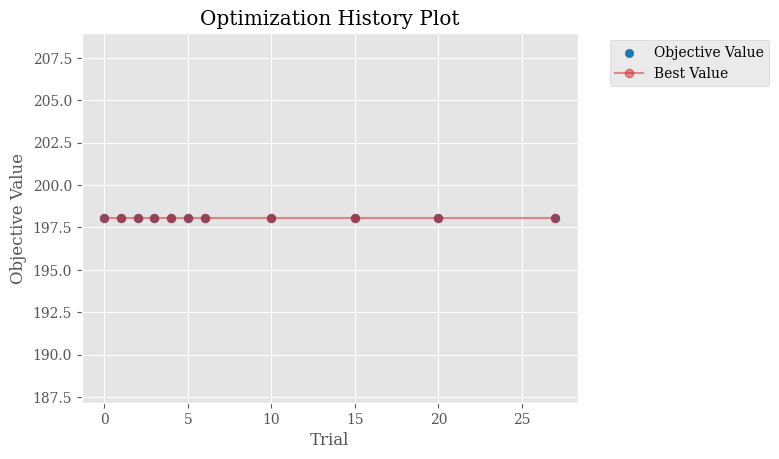

In [ ]:
folder = '/10_lw_dr_al_lr_10_07_23'

# df.to_csv(path+'/network_tuning'+folder+folder+' dataframe.csv')

## Optimization History
title = '/optimization_history'
_ = optuna.visualization.matplotlib.plot_optimization_history(study)


# plt.savefig(path+'/network_tuning'+folder+title, dpi=250)

<ipython-input-43-d6d6ea469e48>:3: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  _ = optuna.visualization.matplotlib.plot_intermediate_values(study)
<ipython-input-43-d6d6ea469e48>:4: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


(0.0, 1.0)

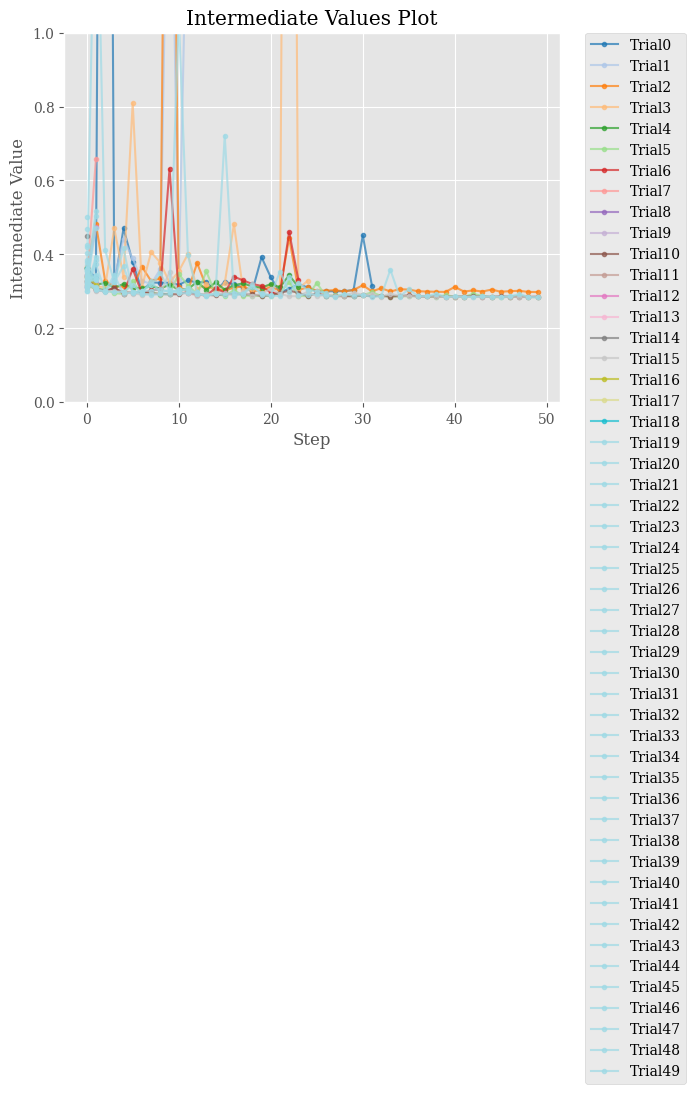

In [ ]:
## Pruning
title = '/pruning'
_ = optuna.visualization.matplotlib.plot_intermediate_values(study)
plt.tight_layout()
plt.ylim(0,1)

# plt.savefig(path+'/network_tuning'+folder+title, dpi=250)

<ipython-input-40-4de2bb28050a>:3: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  _ = optuna.visualization.matplotlib.plot_contour(study)
[W 2023-07-24 13:23:27,588] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
<ipython-input-40-4de2bb28050a>:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


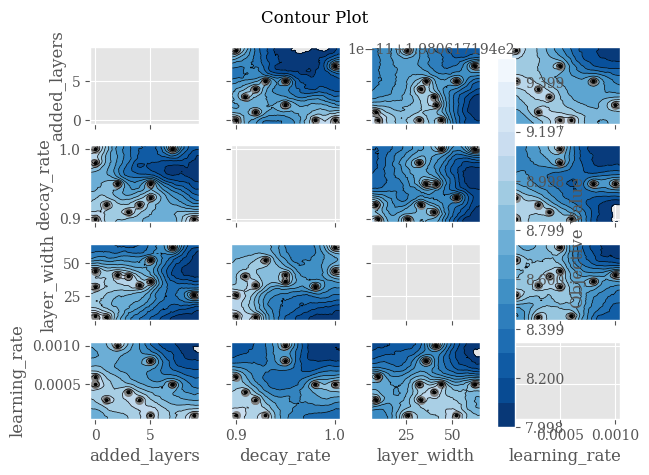

In [ ]:
## Contour
title = '/contour'
_ = optuna.visualization.matplotlib.plot_contour(study)
plt.tight_layout()
# plt.savefig(path+'/network_tuning'+folder+title, dpi=250)

<ipython-input-44-5c3099a3fe99>:3: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  _ = optuna.visualization.matplotlib.plot_param_importances(study)


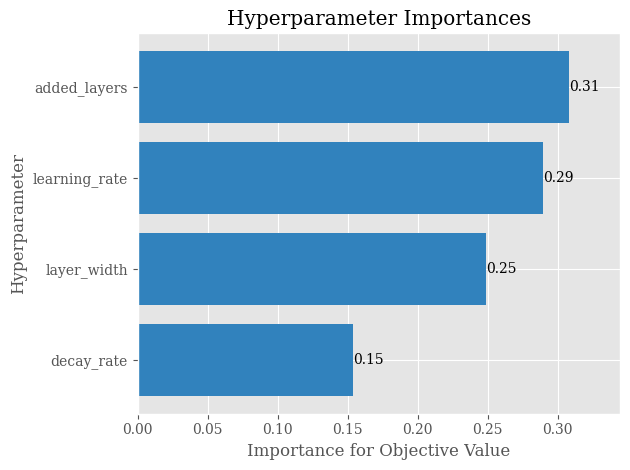

In [ ]:
## Importances
title = '/importance'
_ = optuna.visualization.matplotlib.plot_param_importances(study)
plt.tight_layout()
# plt.savefig(path+'/network_tuning'+folder+title, dpi=250)


<ipython-input-45-bd81848af9f0>:3: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  _ = optuna.visualization.matplotlib.plot_slice(study)


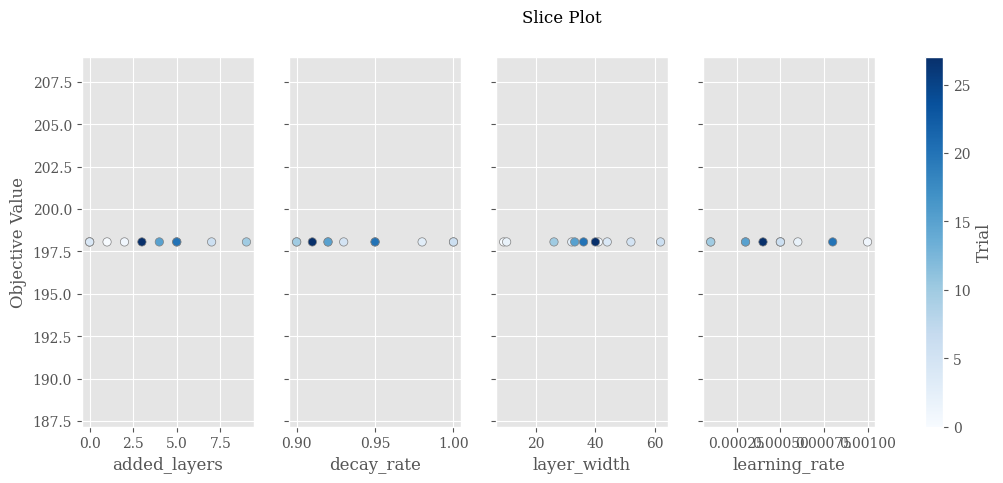

In [ ]:
## plot slice
title = '/plot_slice'
_ = optuna.visualization.matplotlib.plot_slice(study)
# plt.tight_layout()
# plt.savefig(path+'/network_tuning'+folder+title, dpi=250)


## Network tuning
Below I have my own set of plots for tuning hyper-parameters. These may become obsolete after using optuna.

In [23]:
model_instances, model_instances_model,histories,results = [],[],[],[]
# for i in range(len(expt_value)):

# input size, epochs, number of ensembles
N = x_train_scaled.shape[1]
epochs = 100
n_models = 1
#####
validation_model = np.atleast_2d([y_train, 1. - y_train]).T
#######

with tf.device('/device:GPU:0'):
    for model_count in range(n_models):
        model_instances.append(DenseNetwork(N, weight_init='he_normal',
                                            layer_width=45, added_layers=3,
                                            learning_rate=1e-4, decay_rate=0.9,
                                            batch_norm_flag=1))
        model_instances_model.append(model_instances[-1].model())
        # validation_prediction = (model_instances_model[-1].predict(x_test_scaled))
        # print('Initialization: mean =', validation_prediction.mean(), 'std= ', validation_prediction.std())
        # early stopping
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
        histories.append(model_instances_model[-1].fit(x_train_scaled,y_train,
            epochs=epochs, batch_size=150,
                             shuffle=True,
                             validation_data = (x_val_scaled, y_val),
                             callbacks = [early_stop],
                             verbose=1))
        gc.collect()

Hyper-parameters: 2 he_normal 45 3 0.0001 0.9 1 0
Epoch 1/100
2134/2134 [==============================] - 31s 10ms/step - loss: 0.3935 - lr: 9.7784e-05 - val_loss: 0.3099 - val_lr: 9.5602e-05
Epoch 2/100
2134/2134 [==============================] - 23s 11ms/step - loss: 0.3265 - lr: 9.3484e-05 - val_loss: 0.3112 - val_lr: 9.1399e-05
Epoch 3/100
2134/2134 [==============================] - 23s 11ms/step - loss: 0.3203 - lr: 8.9373e-05 - val_loss: 0.3082 - val_lr: 8.7380e-05
Epoch 4/100
2134/2134 [==============================] - 24s 11ms/step - loss: 0.3146 - lr: 8.5444e-05 - val_loss: 0.3042 - val_lr: 8.3537e-05
Epoch 5/100
2134/2134 [==============================] - 23s 11ms/step - loss: 0.3133 - lr: 8.1686e-05 - val_loss: 0.2976 - val_lr: 7.9864e-05
Epoch 6/100
2134/2134 [==============================] - 22s 11ms/step - loss: 0.3085 - lr: 7.8095e-05 - val_loss: 0.3005 - val_lr: 7.6353e-05
Epoch 7/100
2134/2134 [==============================] - 22s 10ms/step - loss: 0.3069 - lr: 

In [24]:
# print the final loss and validation losses
losses, val_losses,stopping = [],[],[]
for i in range(len(histories)):
  losses.append( round(histories[i].history['loss'][-1], 4))
  val_losses.append( round(histories[i].history['val_loss'][-1], 4))
  stopping.append(len(histories[i].history['val_loss']))
  # histories[0].history['loss'][-1]

print('parameter values:\n')
print('losses:\n',losses)
print('val_losses:\n',val_losses)
print('early stopping:\n',stopping)

parameter values:

losses:
 [0.2944]
val_losses:
 [0.2885]
early stopping:
 [100]


(0.75, 1.0)

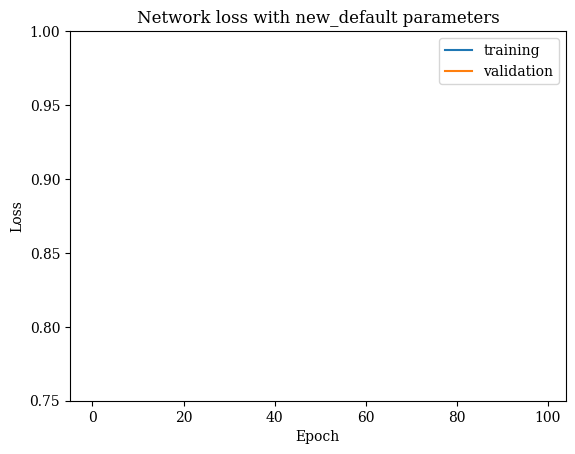

In [25]:
title = 'new_default'

plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.title('Network loss with varying '+title+r' ($\theta$)')
plt.title('Network loss with new_default parameters')
for i in range(len(histories)):
    # if i == 1:
    #     continue

    _ = plt.plot(histories[i].history['loss'][:],label=r'training')#; $\theta$='+str(expt_value[i]))
    _ = plt.plot(histories[i].history['val_loss'][:],label=r'validation')#; $\theta$='+str(expt_value[i]))
    # save the history
    # np.save(path+'/network_tuning/'+title+'_'+str(expt_value[i])+'.npy',histories[0].history)
    # np.save(path+'/network_tuning/'+title+'.npy',histories[0].history)
plt.legend()
plt.ylim(0.75,1)
# plt.xlim(0,90)
# plt.savefig(path+'/network_tuning/'+title, dpi=250)


Metric data can be loaded from the numpy file as below

In [26]:
# note the .item() is important
data = np.load(path+'/network_tuning/batch_size_100.npy',allow_pickle=True).item()
data['val_accuracy'][-1]

0.7307199835777283

## Network Output
The network estimates log K values for the test data. As the ratio of priors is not 1, the network predictions should be transformed to give logK.

In [27]:
# network output f(xO).
validation_prediction = (model_instances_model[-1].predict(x_test_scaled))

# if using l-POP:
# validation_prediction = leaky_parity_odd_power(validation_prediction)
# validation_prediction = validation_prediction.numpy()

print(validation_prediction)

[[29.88162 ]
 [34.05875 ]
 [32.60318 ]
 ...
 [21.533808]
 [37.317215]
 [33.468346]]


In [28]:
# plt.hist(validation_prediction,bins=200)
# plt.plot(validation_prediction,'.')
# plt.ylim(-100,100)


# validation_prediction_mean = np.mean(validation_prediction)
# log_K_net = np.log10(np.exp(validation_prediction_mean))
# print(log_K)




# Coverage tests
Here I've tried to recreate the coverage tests using my own code. First we calculate p(M1|x). We then bin the posterior probabilities and examine the fraction of model 1 labels (SIMBA) in each bin.

In [29]:
# calculate posteriors from network log K values
posterior_model_prob = np.exp(validation_prediction)/(1+np.exp(validation_prediction)) # p(M1|x)
print(posterior_model_prob.shape)

# prepare posterior bins
nbins = 100
probability_array  = np.linspace(0,1,nbins)
# print(probability_array )

(100000, 1)


<ipython-input-29-c67e35dec055>:2: RuntimeWarning: overflow encountered in exp
  posterior_model_prob = np.exp(validation_prediction)/(1+np.exp(validation_prediction)) # p(M1|x)
<ipython-input-29-c67e35dec055>:2: RuntimeWarning: invalid value encountered in true_divide
  posterior_model_prob = np.exp(validation_prediction)/(1+np.exp(validation_prediction)) # p(M1|x)


In [30]:
def coverage_test(post_model_prob, prob_array):
  '''
  Performs the coverage tests to evaluate calibration of the network
  :param post_model_prob: array of p(M1|x) predicted by network
  :param prob_array: array of chosen bins for posteriors
  :returns: posterior bin centres, validation fractions, post_bin_n (number of data prob in each bin),
            binomial_std (standard error of binomial)
  '''

  # perform coverage test
  bin_centres, fractions, post_bin_n = [],[],[]

  for i in range(0,len(probability_array)-1):
    # bin posteriors
    indexes = np.where((posterior_model_prob > probability_array[i])
                                        & (posterior_model_prob < probability_array[i+1]))[0]
    post_bin = posterior_model_prob[indexes]
    post_bin_mid = float((probability_array[i]+probability_array[i+1]) / 2)
    post_bin_size = float(len(post_bin))

    # get fraction of model 1 labels in each bin
    label_bin = y_test[indexes]
    fraction = np.sum(label_bin) / len(label_bin)

    bin_centres.append(post_bin_mid), fractions.append(fraction), post_bin_n.append(post_bin_size)


  # get the binomial error for each bin
  binomial_std = np.sqrt((np.asarray(bin_centres)*(1.-np.asarray(bin_centres))) / np.asarray(post_bin_n))

  return bin_centres, fractions, post_bin_n, binomial_std


In [31]:
bin_centres, fractions, post_bin_n, binomial_std = coverage_test(posterior_model_prob, probability_array)

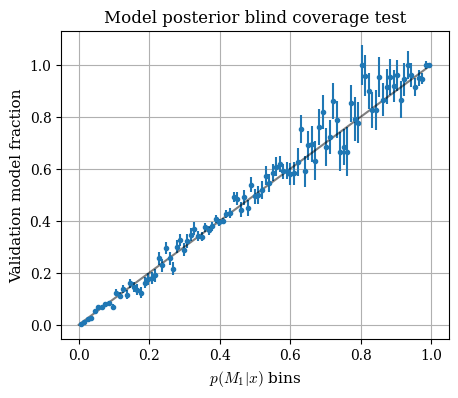

In [32]:
plt.figure(figsize=(5,4))

# plt.plot(bin_centres, fractions,'.')
# plt.plot(post_bin_means, fractions,'.')
plt.errorbar(bin_centres, fractions, np.asarray(binomial_std), marker='.', ls='')
plt.title('Model posterior blind coverage test')
plt.xlabel(r'$p(M_1 | x)$ bins', fontsize=11)
plt.ylabel(str('Validation model fraction'), fontsize=11)
plt.plot([0,1],[0,1],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.savefig(path+'coverage_test_20_B.png', dpi=250)
# plt.axis('equal')

## Residual between model fraction and posterior probability from evidence network

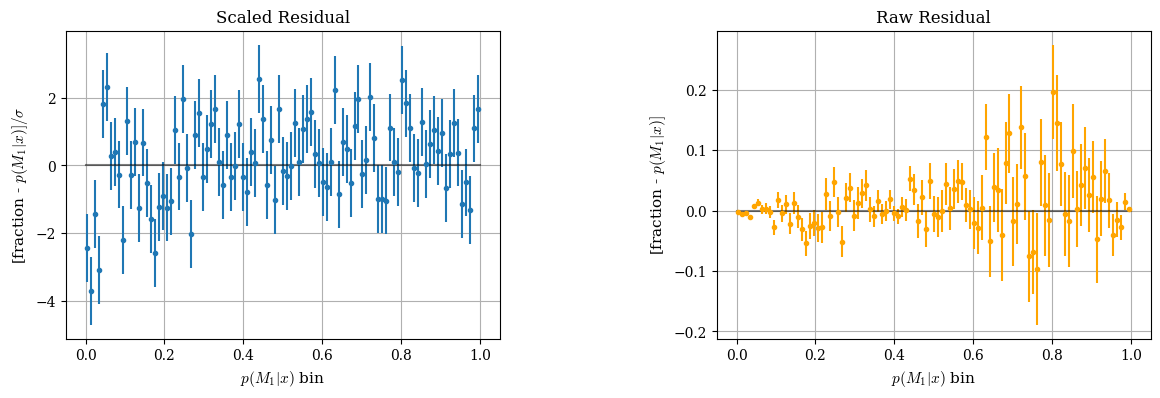

In [33]:
residual = (np.asarray(fractions) - np.asarray(bin_centres))
scaled_residual = residual/np.asarray(binomial_std)

plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
# plt.plot(post_bin_means, residual, marker='.', ls='')
plt.errorbar(bin_centres, scaled_residual,yerr=binomial_std/np.asarray(binomial_std), marker='.', ls='')
# plt.plot(post_bin_means, residual*binomial_std, marker='.', ls='',c='orange')
plt.title('Scaled Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] / \sigma$', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplot(1,2,2)
# plt.plot(post_bin_means, residual, marker='.', ls='')
plt.errorbar(bin_centres, residual,yerr=binomial_std, marker='.', ls='',c='orange')
plt.title('Raw Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] $', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplots_adjust(wspace=.5)


In [34]:
print(np.mean(scaled_residual), np.std(scaled_residual))

0.16123775484427585 1.2233269118459076
